# Import Required Libraries
Import the necessary libraries, including torch, torchvision, and other required modules.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Load CIFAR-10 and CIFAR-10-Corrupted Datasets
Load the CIFAR-10 dataset using torchvision.datasets and CIFAR-10-Corrupted dataset from the appropriate source.

In [2]:
import tarfile
import urllib.request
import os

# Download CIFAR-10-C dataset
# url = "https://zenodo.org/records/2535967/files/CIFAR-10-C.tar?download=1"
# filename = "./data/CIFAR-10-C.tar"
# urllib.request.urlretrieve(url, filename)

# # Extract the dataset
# with tarfile.open(filename, 'r') as tar_ref:
#     tar_ref.extractall("./data")
# os.remove(filename)

# Define transformations for the training and test sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Load CIFAR-10-Corrupted dataset
# corrupted_testset = torchvision.datasets.ImageFolder(root='./data/CIFAR-10-C', transform=transform)
# corrupted_testloader = torch.utils.data.DataLoader(corrupted_testset, batch_size=100,
#                                                    shuffle=False, num_workers=2)

# Define classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import pdb

class NpyCIFAR10CDataset(Dataset):
    """
    A custom dataset for CIFAR-10-C if data is stored in .npy files.
    Expects shape (N, 32, 32, 3) for images and shape (N,) for labels.
    """
    def __init__(self, images_path, labels_path, severity, transform=None):
        super().__init__()
        self.images = np.load(images_path)[(severity - 1)*10000: severity*10000]   # shape: (N, 32, 32, 3)
        self.labels = np.load(labels_path)[(severity - 1)*10000: severity*10000]  # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]    # shape: (32, 32, 3)
        label = self.labels[idx]

        # Convert to float tensor
        img_tensor = torch.from_numpy(img).float()  # shape: (32, 32, 3)

        # Permute to (C, H, W) => (3, 32, 32)
        img_tensor = img_tensor.permute(2, 0, 1)

        # If there's a transform, apply it (e.g., normalization)
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

def get_cifar10c_loader(corruption_type='fog', severity=5, batch_size=64):
    """
    Create a DataLoader for CIFAR-10-C (single corruption or combined),
    assuming .npy files for images and labels.
    """
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    transform = transforms.Compose([
        transforms.Normalize(mean, std)
    ])

    dataset = NpyCIFAR10CDataset(
        images_path=f'/cis/home/xhan56/code/wtr/data/CIFAR-10-C/{corruption_type}.npy',
        labels_path='/cis/home/xhan56/code/wtr/data/CIFAR-10-C/labels.npy',
        severity=severity,
        transform=transform
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return loader

In [10]:
class MixtureCIFARDataset(Dataset):
    """
    A dataset that returns a mixture of clean CIFAR-10 samples and
    corrupted CIFAR-10 samples at a specified mixture ratio.

    Args:
        clean_dataset (Dataset): A PyTorch dataset for standard CIFAR-10.
        corrupted_dataset (Dataset): A PyTorch dataset for the corrupted CIFAR-10 (e.g. one severity level).
        mixture_ratio (float): Probability of drawing a corrupted sample (0 <= ratio <= 1).
        total_size (int, optional): How many total samples to emulate for this mixture.
            If None, defaults to the max length of the two input datasets.
        transform (callable, optional): Optional transform to be applied on the image after loading.
    """
    def __init__(self, 
                 clean_dataset, 
                 corrupted_dataset, 
                 mixture_ratio=0.5,
                 total_size=None,
                 transform=None):
        super().__init__()
        self.clean_dataset = clean_dataset
        self.corrupted_dataset = corrupted_dataset
        self.mixture_ratio = mixture_ratio
        self.transform = transform

        if total_size is None:
            self.total_size = max(len(self.clean_dataset), len(self.corrupted_dataset))
        else:
            self.total_size = total_size

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        """
        Stochastically choose either a corrupted sample or a clean sample
        according to mixture_ratio.
        """
        # With probability mixture_ratio, pick from corrupted
        # Otherwise, pick from clean.
        if np.random.rand() < self.mixture_ratio:
            img, label = self.corrupted_dataset[idx]
        else:
            img, label = self.clean_dataset[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Normalize(mean, std)
])
corruption_type = 'gaussian_blur'
severity = 4
train_c_dataset = NpyCIFAR10CDataset(
    images_path=f'/cis/home/xhan56/code/wtr/data/CIFAR-10-C/{corruption_type}.npy',
    labels_path='/cis/home/xhan56/code/wtr/data/CIFAR-10-C/labels.npy',
    severity=severity,
    transform=transform
)
train_dataset, val_dataset = random_split(trainset, [40000, 10000])
mixture_dataset = MixtureCIFARDataset(
    clean_dataset=val_dataset,
    corrupted_dataset=train_c_dataset,
    mixture_ratio=0.9,
    transform=transform
)
loader = DataLoader(
    dataset=mixture_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=False
)

for i, data in enumerate(loader):
    print(data[0].shape)
    print(data[1].shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


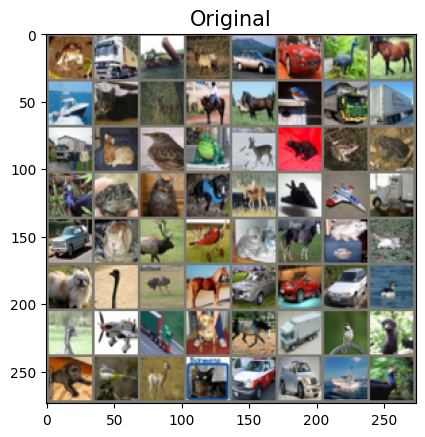

In [91]:
# Visualize Sample Images
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2023, 0.1994, 0.2010])

    img = img * std[:, None, None] + mean[:, None, None]  # unnormalize
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title('Original', fontsize=15)
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


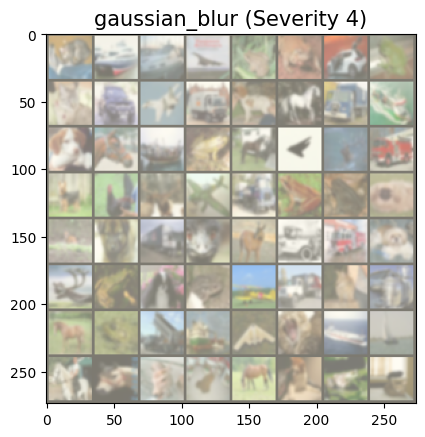

In [94]:
def imshow_cifar_c(img, corruption_type, severity):
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std = torch.tensor([0.2470, 0.2435, 0.2616])

    img = img * std[:, None, None] + mean[:, None, None]  # unnormalize
    npimg = img.numpy()
    # npimg = np.clip(npimg, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(f'{corruption_type} (Severity {severity})', fontsize=15)
    plt.show()

corruption_type = 'gaussian_blur'
severity = 4
loader = get_cifar10c_loader(corruption_type=corruption_type, severity=severity)
dataiter = iter(loader)
images, labels = next(dataiter)

imshow_cifar_c(torchvision.utils.make_grid(images) / 500.0, corruption_type, severity)  # Normalize to [0, 1] range

# Define the MLP Model
Define a multi-layer perceptron (MLP) model using torch.nn.Module.

In [13]:
# Define the MLP Model

class MLP(nn.Module):
    """
    A simple MLP for CIFAR-10 classification.
    Input: (N, 3, 32, 32)
    Output: (N, 10) for 10 classes.
    """
    def __init__(self, input_size=3*32*32, hidden_size=1024, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (N, 3, 32, 32)
        # Flatten to (N, 3*32*32 = 3072)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
        # Define the ResNet-32 Model

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet32():
    return ResNet(BasicBlock, [5, 5, 5])

# Set Up Training and Evaluation Functions
Set up functions to train and evaluate the model, including loss calculation and optimization steps.

In [14]:
# Set Up Training and Evaluation Functions

def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(dim=1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, device, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(dim=1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Train the Model on CIFAR-10
Train the MLP model on the CIFAR-10 dataset using the defined training function.

In [19]:
# Train the Model on CIFAR-10
lr = 1e-3
epochs = 10
batch_size = 64
train_clean = True
corruption_type = 'fog'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Build model
model = MLP(input_size=3*32*32, hidden_size=1024, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader_c = get_cifar10c_loader(corruption_type=corruption_type, severity=4, batch_size=batch_size)
test_loader_c = get_cifar10c_loader(corruption_type=corruption_type, severity=4, batch_size=batch_size)
# Training loop
for epoch in range(epochs):
    if train_clean:
        train_loss, train_acc = train_one_epoch(model, device, trainloader, optimizer, criterion)
    else:
        train_loss, train_acc = train_one_epoch(model, device, train_loader_c, optimizer, criterion)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

    # Evaluate on both clean and corrupted (if available)
    clean_loss, clean_acc = evaluate(model, device, testloader, criterion)
    print(f"   Clean Test Loss: {clean_loss:.4f}, Clean Acc: {clean_acc*100:.2f}%")

    c_loss, c_acc = evaluate(model, device, test_loader_c, criterion)
    print(f"   Corrupted Test Loss: {c_loss:.4f}, Corrupted Acc: {c_acc*100:.2f}%")

Epoch [1/10] - Train Loss: 1.6656, Train Acc: 40.89%
   Clean Test Loss: 1.5365, Clean Acc: 45.08%
   Corrupted Test Loss: 264.2964, Corrupted Acc: 16.59%
Epoch [2/10] - Train Loss: 1.4688, Train Acc: 47.93%
   Clean Test Loss: 1.4846, Clean Acc: 47.80%
   Corrupted Test Loss: 598.6357, Corrupted Acc: 12.93%
Epoch [3/10] - Train Loss: 1.3585, Train Acc: 52.07%
   Clean Test Loss: 1.4057, Clean Acc: 50.62%
   Corrupted Test Loss: 598.3467, Corrupted Acc: 15.35%
Epoch [4/10] - Train Loss: 1.2777, Train Acc: 54.96%
   Clean Test Loss: 1.4403, Clean Acc: 50.36%
   Corrupted Test Loss: 259.4511, Corrupted Acc: 13.99%
Epoch [5/10] - Train Loss: 1.2069, Train Acc: 57.25%
   Clean Test Loss: 1.4333, Clean Acc: 50.96%
   Corrupted Test Loss: 667.0127, Corrupted Acc: 11.74%
Epoch [6/10] - Train Loss: 1.1333, Train Acc: 59.77%
   Clean Test Loss: 1.4319, Clean Acc: 51.84%
   Corrupted Test Loss: 920.3001, Corrupted Acc: 11.37%
Epoch [7/10] - Train Loss: 1.0646, Train Acc: 62.22%
   Clean Test Los

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Alibi Detect
from alibi_detect.datasets import fetch_cifar10c

In [11]:
class CIFAR10CDataset(Dataset):
    """
    Wrap X, y from fetch_cifar10c (N, 32, 32, 3) arrays into a PyTorch dataset.
    Applies optional transforms or normalization.
    """
    def __init__(self, X, y, transform=None):
        super().__init__()
        self.X = X   # shape: (N, 32, 32, 3)
        self.y = y   # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]    # (32, 32, 3)
        label = self.y[idx]

        # Convert to float32 tensor and reorder to (C, H, W):
        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1)
        
        # Apply transform (e.g. normalization)
        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

In [ ]:
def load_cifar10c_dataloader(corruption='gaussian_noise', severity=1, batch_size=64):
    """
    Fetch a single corruption type + severity from CIFAR-10-C via alibi_detect,
    wrap in a DataLoader for training or evaluation.
    """

    # 1) Fetch the data -> (X, y) as NumPy arrays
    X, y = fetch_cifar10c(
        corruption=corruption,
        severity=severity,
        return_X_y=True
    )
    print(f"Fetched CIFAR-10-C: corruption={corruption}, severity={severity}, shape={X.shape}")

    # 2) Define transforms (common CIFAR-10 normalization)
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)
    transform = transforms.Compose([
        transforms.Normalize(mean, std)
    ])

    # 3) Create custom dataset and dataloader
    dataset = CIFAR10CDataset(X, y, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [13]:
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Compute accuracy
        _, predicted = outputs.max(dim=1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, device, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(dim=1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def main():
    # Hyperparameters
    corruption = "gaussian_noise"  # e.g. "motion_blur", "jpeg_compression", etc.
    severity = 1                   # integer 1..5
    batch_size = 64
    epochs = 5
    lr = 1e-3

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1) Load CIFAR-10-C train data (for demonstration, we assume we "train" on the corrupted set)
    train_loader = load_cifar10c_dataloader(
        corruption=corruption,
        severity=severity,
        batch_size=batch_size
    )

    # If you'd like a different severity or corruption for "test", do it here:
    # test_loader = load_cifar10c_dataloader(corruption='motion_blur', severity=3, batch_size=batch_size)
    # or re-use the same train_loader as test_loader for demonstration
    test_loader = train_loader

    # 2) Build the MLP model
    model = MLP(input_size=3*32*32, hidden_size=1024, num_classes=10).to(device)

    # 3) Optimizer & loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 4) Training loop
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, device, train_loader, optimizer, criterion)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}")

        test_loss, test_acc = evaluate(model, device, test_loader, criterion)
        print(f"           Test Loss: {test_loss:.4f},  Test Acc: {test_acc:.2%}")